In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.53298
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.51899


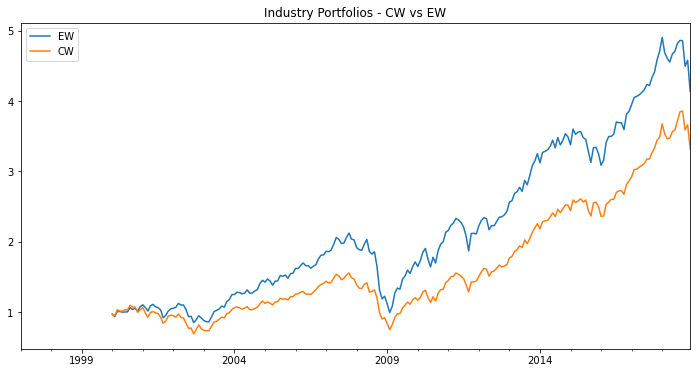

In [20]:
ind30_rets = erk.get_ind_returns(weighting="vw", n_inds=30)["1997":]
ind30_mcap = erk.get_ind_market_caps(30, weights=True)["1997":]

ewr = erk.backtest_ws(ind30_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind30_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind30_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

#### Re-run the EW backtest but this time create a tethered EW portfolio by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X.

In [21]:
def weight_ewtr(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

In [22]:
ewtr = erk.backtest_ws(ind30_rets, estimation_window=36, weighting=weight_ewtr, \
                       cap_weights = ind30_mcap, max_cw_mult = 2, microcap_threshold = 0.01)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
Tethered EW,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413


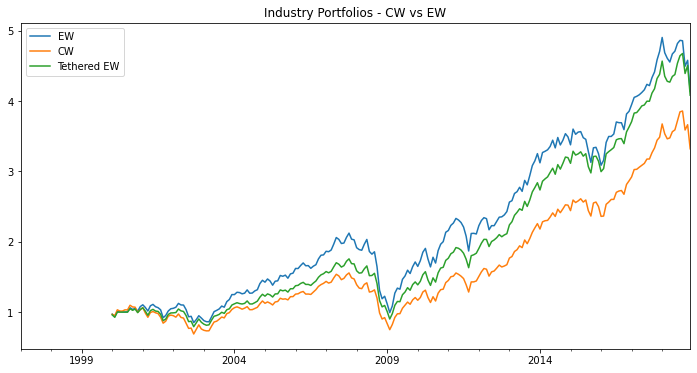

In [23]:
btr["Tethered EW"] = ewtr
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

In [32]:
erk.tracking_error(ewr, cwr)

0.18752094143646486

In [33]:
erk.tracking_error(ewtr, cwr)

0.11671015519949166

#### Run a backtest for the same period (1997 onwards i.e. 1997 included, 1996 not included, 2018 included), using an estimation window of 36 months as above, to build the Global Minimum Variance Portfolio by estimating the Covariance matrix using Sample Covariance. 

In [25]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
Tethered EW,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413
GMV-Sample Cov,0.066306,0.117410,-0.741088,4.469211,0.055456,0.080583,0.300817,-0.421289


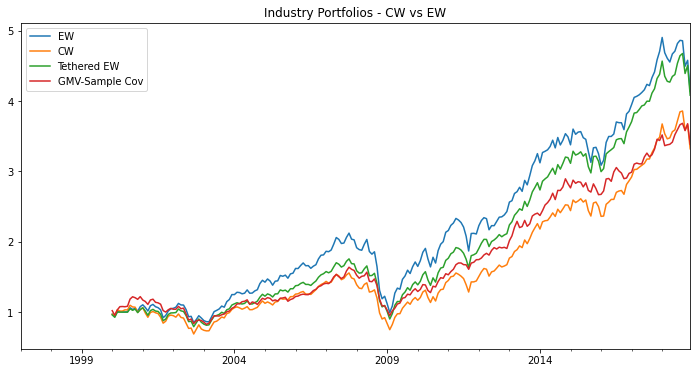

In [26]:
mv_s_r = erk.backtest_ws(ind30_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr["GMV-Sample Cov"] = mv_s_r
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

In [29]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
#     mh.corr2cov(ccor, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

def shrinkage_cov(r, delta=0.25, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
Tethered EW,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413
GMV-Sample Cov,0.066306,0.117410,-0.741088,4.469211,0.055456,0.080583,0.300817,-0.421289
GMV-Shrinkage,0.068467,0.114572,-0.731291,4.264941,0.053884,0.077715,0.326632,-0.393410


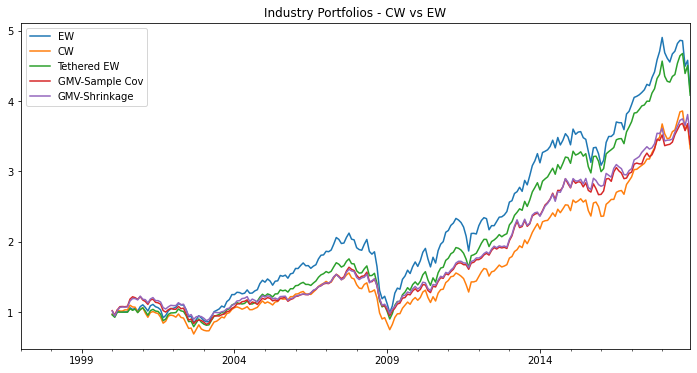

In [30]:
btr["GMV-Shrinkage"] = erk.backtest_ws(ind30_rets, estimation_window=36, \
                                       weighting=weight_gmv, cov_estimator=shrinkage_cov)
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())